In [21]:
import pandas as pd
import numpy as np
import requests
import json
import fiona
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 15


coc=pd.read_csv('../Data/Clean/CoC/CoC_geocoded.csv')
key=pd.read_csv('../Data/Clean/DANE_CoC_matching.csv')

dane = gpd.read_file("../Data/Clean/DANE/DANE_joined.shp")
#dane = gpd.read_file('Data/Raw/DANE/Manzanas_CNUE_Marco_DEST_290722.shp')
key['ISIC']=pd.to_numeric(key['ISIC'],errors='coerce')

#print(coc[coc['isic_2']==47].groupby(['isic_4','isic_4_lab']).size().sort_values(ascending=False).head(10))
#print(coc.groupby(['isic_2','isic_2_lab']).size().sort_values(ascending=False).head(10))

In [14]:
counts=coc.groupby(['isic_2','isic_2_lab']).size().sort_values(ascending=False).head(20).reset_index().rename(columns={0:'count'})
px.bar(counts, x=counts['isic_2'].astype(str), y=counts['count'], title='Top 20 ISIC 2', hover_data=['isic_2_lab'])

In [41]:
def plot_choropleth(code,style):
    
    text=coc[coc['isic_'+str(len(str(code)))]==code]['isic_'+str(len(str(code)))+'_lab'].unique()[0]
    coc_f=coc[(coc['isic_'+str(len(str(code)))]==code)&(coc['lon']>-76)][['lat','lon']]

    key_f=key[key['ISIC']==code]

    names=list(key_f['Field Name'].str.upper().str.replace(' ','_').str[:10])

    cols=['geometry']+names
    dane_f=dane[cols]
    gdf = gpd.GeoDataFrame(
        coc_f, geometry=gpd.points_from_xy(coc_f.lon, coc_f.lat), crs=dane_f.crs)

    joined=gpd.sjoin(gdf, dane_f[['geometry']], how="inner", op='intersects')

    joined['const']=1

    joined=joined.groupby(['index_right']).sum()
    dane_f['index_right']=dane_f.index
    merged=dane_f.merge(joined, on='index_right', how='left')
    merged['const']=merged['const'].fillna(0)
    merged['ratio']=merged['const']-(merged[names].sum(axis=1))
    summary=merged['ratio'].describe()

    title='Ratio of CoC establishments to DANE establishments for ISIC {} \n ({})'.format(code, text)

    if style=='plotly':
        fig=px.choropleth(merged, geojson=merged.geometry, locations=merged.index, color='ratio', color_continuous_scale="Viridis", range_color=(-10,0))
        fig.update_geos(fitbounds="locations", visible=False)
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0}, height=1000, width=800, title=title)
        fig.show()

    if style=='matplotlib':

        base = dane_f.plot(color='white', edgecolor='grey')
        merged.plot(column='ratio',ax=base, legend=True,vmin=-10, vmax=0)
        plt.title(title)
        plt.savefig('../Figures/{}_{}.jpg'.format(code, text))
        #plt.show()



In [44]:
style='matplotlib'
codes=coc['isic_2'].unique()
#for code in codes:
    #plot_choropleth(code,style)

/var/folders/6q/jt4x0r8n1rs0kbrrqrbj61fr0000gn/T/ipykernel_57230/4275273565.py:12: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

/var/folders/6q/jt4x0r8n1rs0kbrrqrbj61fr0000gn/T/ipykernel_57230/4275273565.py:17: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



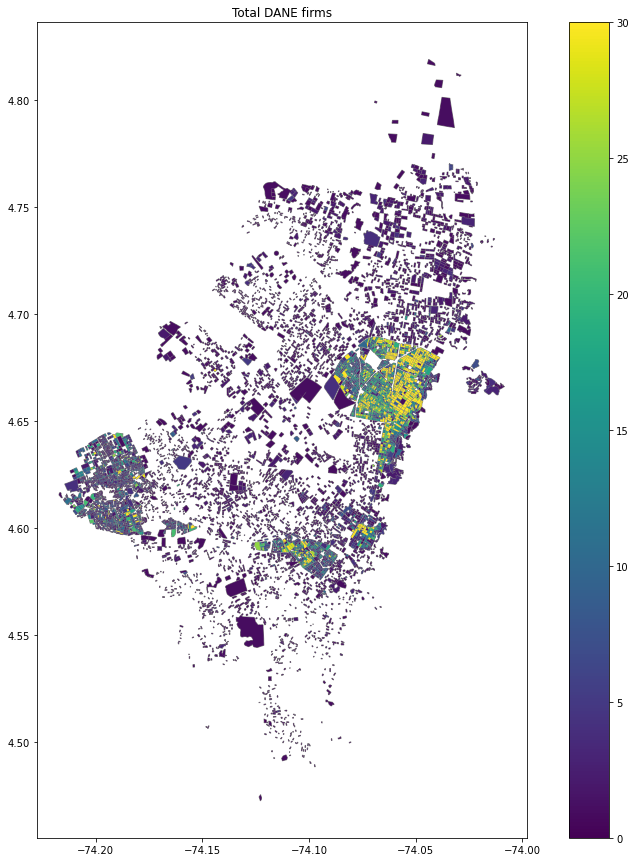

In [73]:

coc_f=coc[coc['lon']>-76][['lat','lon']]

gdf = gpd.GeoDataFrame(
    coc_f, geometry=gpd.points_from_xy(coc_f.lon, coc_f.lat), crs=dane.crs)

joined=gpd.sjoin(gdf, dane[['geometry']], how="inner", op='intersects')

joined['const']=1

joined=joined.groupby(['index_right']).sum()
dane['index_right']=dane.index
dane['sum']=dane.sum(axis=1)
['ratio', 'geometry', 'index_right', 'sum']
merged=dane.merge(joined, on='index_right', how='left')

merged['const']=merged['const'].fillna(0)
merged['dane']=merged.sum(axis=1)
merged['ratio']=merged['const']-(merged['dane_total'])

summary=merged['ratio'].describe()

title='Total DANE firms'


base = dane.plot(color='white', edgecolor='grey')
merged.plot(column='const',ax=base, legend=True,vmin=0, vmax=30)
plt.title(title)
plt.savefig('../Figures/COC_Total.jpg')
plt.show()